In [1]:
import os
import gc
import sys
import glob
import numpy as np
import pandas as pd
import netCDF4 as nc
from datetime import datetime, timedelta
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import matplotlib.ticker as mticker

# Check PLUMBER 2 input file

### Check GFDL

In [3]:
PLUMBER2_path      = "/g/data/w97/mm3972/data/PLUMBER2/"
PLUMBER2_flux_path = "/g/data/w97/mm3972/data/Fluxnet_data/Post-processed_PLUMBER2_outputs/Nc_files/Flux/"
PLUMBER2_met_path  = "/g/data/w97/mm3972/data/Fluxnet_data/Post-processed_PLUMBER2_outputs/Nc_files/Met/"

In [38]:
model_name = 'GFDL'
site_name  = 'US-Me4'

In [58]:
file_path      = glob.glob(PLUMBER2_path+model_name +"/*"+site_name+"*.nc")
fmodel         = nc.Dataset(file_path[0]) 
file_path      = glob.glob(PLUMBER2_flux_path+"*"+site_name+"*.nc")
fobs           = nc.Dataset(file_path[0]) 

Qle_model = fmodel.variables['Qle'][:]
Qle_obs   = fobs.variables['Qle'][:]


Qle_model_tot  = len(fmodel.variables['Qle'])
Qle_obs_tot    = len(fobs.variables['Qle'])
# print(Qle_model)

Qle_model_neg  = np.sum(np.where(Qle_model<-1000.,1,0))
Qle_obs_neg    = np.sum(np.where(Qle_obs<-999.,1,0))
# print(Qle_model_neg,Qle_obs_neg)
obs = Qle_obs_neg/Qle_obs_tot*100.
model = Qle_model_neg/Qle_model_tot*100.
# print('site', site_name, 'model:', str(model),', obs:', str(obs))


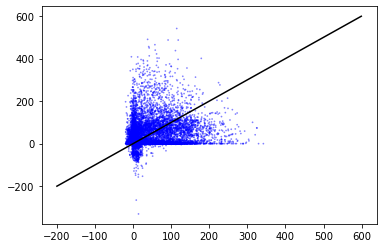

In [40]:
plt.scatter(Qle_obs[:,0,0],Qle_model[:,0,0], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-200,600),np.arange(-200,600),c='black')

140256

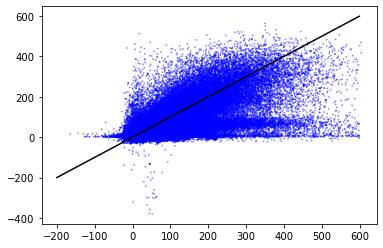

In [6]:
model_name = 'CABLE'
site_name  = 'AU-Tum'
file_path      = glob.glob(PLUMBER2_path+model_name +"/*"+site_name+"*.nc")
fmodel         = nc.Dataset(file_path[0]) 
file_path      = glob.glob(PLUMBER2_flux_path+"*"+site_name+"*.nc")
fobs           = nc.Dataset(file_path[0]) 

Qle_model = fmodel.variables['Qle']
Qle_obs   = fobs.variables['Qle']
plt.scatter(Qle_obs[:,0,0],Qle_model[:,0,0], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-200,600),np.arange(-200,600),c='black')
len(Qle_obs)

In [7]:
output_file      = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/nc_files/"+site_name+".nc"
f                = nc.Dataset(output_file)
Qle_cable        = f.variables['CABLE_Qle'][:]
Qle_gfdl         = f.variables['GFDL_Qle'][:]
Qle_obs          = f.variables['obs_Qle'][:]


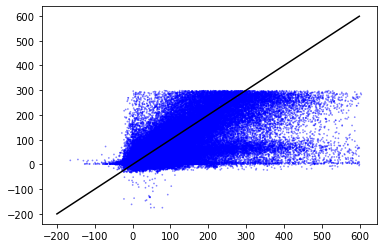

In [8]:
plt.scatter(Qle_obs[:],Qle_cable[:], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-200,600),np.arange(-200,600),c='black')

# Check sites have negative Qle values in GFDL

In [61]:
PLUMBER2_path  = "/g/data/w97/mm3972/data/Fluxnet_data/Post-processed_PLUMBER2_outputs/Nc_files/Met/"
all_site_path  = sorted(glob.glob(PLUMBER2_path+"/*.nc"))
site_names     = [os.path.basename(site_path).split("_")[0] for site_path in all_site_path]
# site_names

In [62]:
PLUMBER2_path      = "/g/data/w97/mm3972/data/PLUMBER2/"
for site_name in site_names:
    # print(site_name)
    file_path      = glob.glob(PLUMBER2_path +"GFDL/*"+site_name+"*.nc")

    fmodel         = nc.Dataset(file_path[0]) 
    file_path      = glob.glob(PLUMBER2_flux_path+"*"+site_name+"*.nc")
    fobs           = nc.Dataset(file_path[0]) 

    Qle_model      = np.squeeze(fmodel.variables['Qle'])
    Qle_obs        = np.squeeze(fobs.variables['Qle'])
    
    Qle_model_tot  = len(fmodel.variables['Qle'])
    Qle_obs_tot    = len(fobs.variables['Qle'])
    # print(Qle_model)
    
    Qle_model_neg  = np.sum(np.where(Qle_model<-200.,1,0))
    Qle_obs_neg    = np.sum(np.where(Qle_obs<-200.,1,0))
    # print(Qle_model_neg,Qle_obs_neg)
    obs = Qle_obs_neg/Qle_obs_tot*100.
    model = Qle_model_neg/Qle_model_tot*100.
    # print('site', site_name, 'model:', str(model),', obs:', str(obs))

# Quality control

In [24]:
def conduct_quality_control(varname, data_input,zscore_threshold=2):

    '''
    Please notice EF has nan values
    '''

    z_scores    = np.abs(stats.zscore(data_input, nan_policy='omit'))
    data_output = np.where(z_scores > zscore_threshold, np.nan, data_input)
    print("zscore_threshold",zscore_threshold,"",np.sum(np.isnan(data_output))/len(data_output))
    # print('z_scores',z_scores)
    if 'EF' not in varname:
        print('EF is not in ', varname)
        # Iterate through the data to replace NaN with the average of nearby non-NaN values
        for i in range(1, len(data_output) - 1):
            if np.isnan(data_output[i]):
                prev_index = i - 1
                next_index = i + 1

                # find the closest non nan values
                while prev_index >= 0 and np.isnan(data_output[prev_index]):
                    prev_index -= 1

                while next_index < len(data_output) and np.isnan(data_output[next_index]):
                    next_index += 1

                # use average them
                if prev_index >= 0 and next_index < len(data_output):
                    prev_non_nan = data_output[prev_index]
                    next_non_nan = data_output[next_index]
                    data_output[i] = (prev_non_nan + next_non_nan) / 2.0

    print('len(z_scores)',len(z_scores))
    # print('data_output',data_output)

    return data_output


In [25]:

from scipy import stats, interpolate
Qle_model_qc = conduct_quality_control('Qle', Qle_model,4)
Qle_obs_qc = conduct_quality_control('Qle', Qle_obs,4)

zscore_threshold 4  0.006402578142824549
EF is not in  Qle
len(z_scores) 140256
zscore_threshold 4  0.005803673283139402
EF is not in  Qle
len(z_scores) 140256


[[[6.075706 ]]

 [[4.7818284]]

 [[2.9377463]]

 ...

 [[8.632171 ]]

 [[7.86823  ]]

 [[7.328048 ]]]


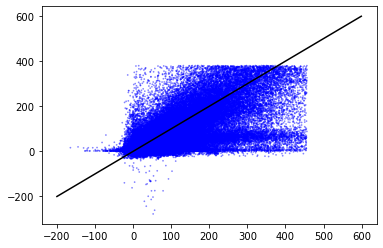

In [26]:
plt.scatter(Qle_obs_qc[:],Qle_model_qc[:], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-200,600),np.arange(-200,600),c='black')
len(np.isnan(Qle_model_qc[:]))
len(np.isnan(Qle_obs_qc[:]))
print(Qle_model_qc)

# Check PLUMBER 2 process1 output file

## Check Qle

In [2]:
PLUMBER2_txt = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/"
process_name = "process1_output"
var_output   = pd.read_csv(f'{PLUMBER2_txt}{process_name}/Qle_all_sites.csv',na_values=[''],usecols=['site_name','obs','model_GFDL','model_CABLE'])

FileNotFoundError: [Errno 2] No such file or directory: '/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Qle_all_sites.csv'

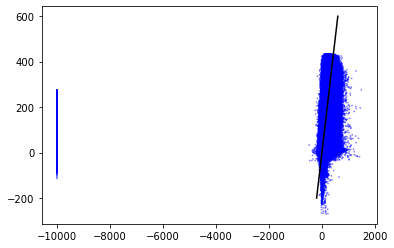

In [67]:
# site_name = "US-Me4"
# site_mask = var_output['site_name'].values == site_name
# plt.scatter(var_output[site_mask]['obs'],var_output[site_mask]['model_CABLE'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.scatter(var_output['obs'],var_output['model_CABLE'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-200,600),np.arange(-200,600),c='black')

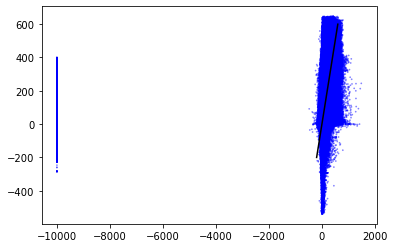

In [30]:
plt.scatter(var_output['obs'],var_output['model_GFDL'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-200,600),np.arange(-200,600),c='black')

## Check Qle filter

In [2]:
PLUMBER2_txt = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/"
process_name = "process1_output"
# var          = pd.read_csv(f'{PLUMBER2_txt}{process_name}/Qle_all_sites_not_filtered.csv',na_values=[''],usecols=['site_name','obs','model_GFDL','model_CABLE'])
var_filter   = pd.read_csv(f'{PLUMBER2_txt}{process_name}/Qle_all_sites_filter_4sigma.csv',na_values=[''],usecols=['site_name','obs','model_GFDL','model_CABLE'])
var_filter_3sigma = pd.read_csv(f'{PLUMBER2_txt}{process_name}/backup/Qle_all_sites_with_LAI.csv',na_values=[''],usecols=['site_name','obs','model_GFDL','model_CABLE'])


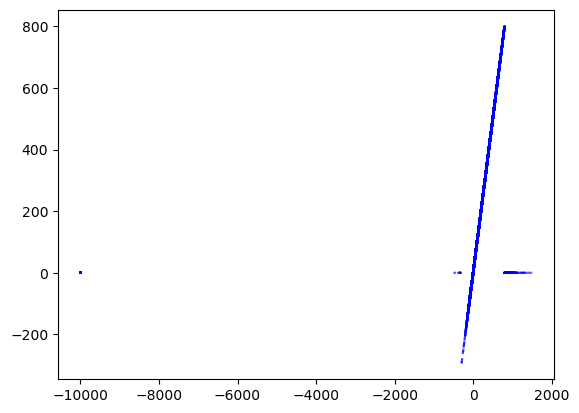

In [15]:
model_var            = var_filter_3sigma['obs']
model_var_filter     = var_filter['obs']
model_var_filter_new = np.where( (np.isnan(model_var_filter)) & (~ np.isnan(model_var)), 0, model_var_filter)

plt.scatter(model_var,model_var_filter_new, s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
# plt.plot(np.arange(0,5),np.arange(0,5),c='black')

In [ ]:
model_var            = var_filter_3sigma['obs']
model_var_filter     = var_filter['obs']
model_var            = np.where( (np.isnan(model_var)) & (~ np.isnan( model_var_filter)), 0, model_var)
# print((np.sum(model_var != model_var_filter)-np.sum(np.all([np.isnan(model_var), np.isnan(model_var_filter)],axis=0)))/len(model_var))
plt.scatter(model_var,model_var_filter, s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
# plt.plot(np.arange(0,5),np.arange(0,5),c='black')

(array([1.06104774e-07, 0.00000000e+00, 0.00000000e+00, 1.06104774e-07,
        1.06104774e-07, 5.30523871e-08, 0.00000000e+00, 5.30523871e-08,
        0.00000000e+00, 5.30523871e-08, 1.06104774e-07, 5.30523871e-08,
        5.30523871e-08, 1.06104774e-07, 1.06104774e-07, 5.30523871e-08,
        0.00000000e+00, 5.30523871e-08, 1.06104774e-07, 0.00000000e+00,
        1.06104774e-07, 1.06104774e-07, 0.00000000e+00, 0.00000000e+00,
        5.30523871e-08, 1.06104774e-07, 0.00000000e+00, 1.06104774e-07,
        1.06104774e-07, 1.06104774e-07, 1.59157161e-07, 1.06104774e-07,
        2.12209548e-07, 0.00000000e+00, 0.00000000e+00, 1.06104774e-07,
        1.59157161e-07, 5.30523871e-08, 1.59157161e-07, 1.59157161e-07,
        1.59157161e-07, 1.06104774e-07, 0.00000000e+00, 0.00000000e+00,
        5.30523871e-08, 1.06104774e-07, 0.00000000e+00, 5.30523871e-08,
        0.00000000e+00, 1.06104774e-07, 1.06104774e-07, 2.12209548e-07,
        5.30523871e-08, 5.30523871e-08, 1.06104774e-07, 0.000000

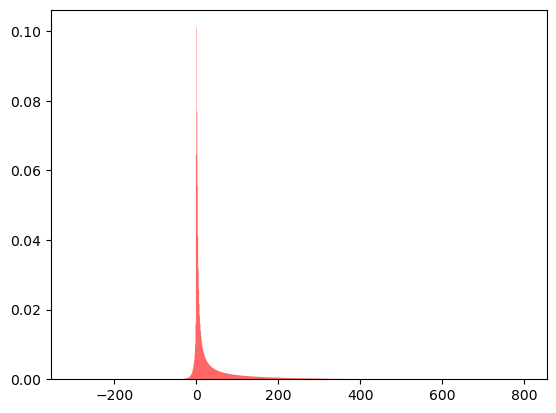

In [6]:
plt.hist(var_filter['model_CABLE'], bins=1000, density=True, alpha=0.6, color='red',label='pdf', histtype='stepfilled')

In [10]:
np.nan == np.nan

False

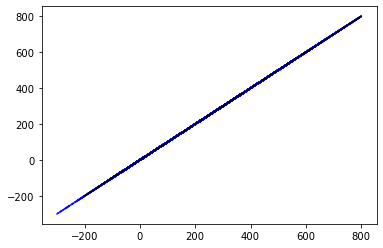

In [15]:
plt.scatter(var['model_CABLE'],var['model_CABLE'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-200,800),np.arange(-200,800),c='black')

In [24]:
max(var_filter['model_CABLE'])

799.94495

In [25]:
max(var['model_CABLE'])

799.94495

## Check LAI

In [1]:
PLUMBER2_txt = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/"
process_name = "process1_output"
var_output   = pd.read_csv(f'{PLUMBER2_txt}{process_name}/LAI_all_sites_parallel.csv',na_values=[''])

NameError: name 'pd' is not defined

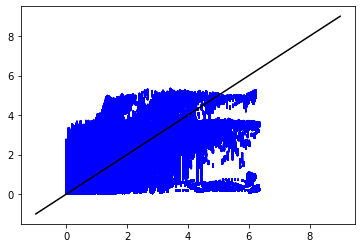

In [95]:
# obs_LAI,ORC2_r6593_LAI,ORC2_r6593_CO2_LAI,ORC3_r7245_NEE_LAI,ORC3_r8120_LAI,GFDL_LAI,SDGVM_LAI,QUINCY_LAI,NoahMPv401_LAI

plt.scatter(var_output['obs_LAI'],var_output['NoahMPv401_LAI'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')

## Check Gs

In [3]:
var_output   = pd.read_csv("/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Gs_all_sites.csv",
                           na_values=[''],usecols=["model_CABLE","CABLE_VPDl","obs","obs_VPDl","model_CABLE-POP-CN","CABLE-POP-CN_VPDl"])

# ,usecols=["model_CABLE","CABLE_VPDl","obs","obs_VPDl","model_CABLE-POP-CN","CABLE-POP-CN_VPDl",
#                                                    "model_MATSIRO","model_MuSICA","model_JULES_GL9_withLAI","model_JULES_test",
#                                                    "model_QUINCY","model_ORC3_r7245_NEE","model_ORC3_r8120"]
# ,time,CABLE_EF,CABLE-POP-CN_EF,CHTESSEL_ERA5_3_EF,CHTESSEL_Ref_exp1_EF,CLM5a_EF,GFDL_EF,JULES_GL9_withLAI_EF,JULES_test_EF,MATSIRO_EF,MuSICA_EF,NASAEnt_EF,NoahMPv401_EF,ORC2_r6593_EF,ORC2_r6593_CO2_EF,ORC3_r7245_NEE_EF,ORC3_r8120_EF,QUINCY_EF,STEMMUS-SCOPE_EF,obs_EF,VPD,obs_Tair,obs_Qair,obs_Precip,obs_SWdown,NoahMPv401_greenness,month,hour,site_name,IGBP_type,climate_type,half_hrs_after_precip,
# model_CABLE,CABLE_VPDl,model_CABLE-POP-CN,CABLE-POP-CN_VPDl,model_CHTESSEL_ERA5_3,
# CHTESSEL_ERA5_3_VPDl,model_CHTESSEL_Ref_exp1,CHTESSEL_Ref_exp1_VPDl,model_CLM5a,
# CLM5a_VPDl,model_GFDL,GFDL_VPDl,model_JULES_GL9_withLAI,JULES_GL9_withLAI_VPDl,
# model_JULES_test,JULES_test_VPDl,model_MATSIRO,MATSIRO_VPDl,model_MuSICA,MuSICA_VPDl,
# model_NASAEnt,NASAEnt_VPDl,model_NoahMPv401,NoahMPv401_VPDl,model_ORC2_r6593
# ORC2_r6593_VPDl,model_ORC2_r6593_CO2,ORC2_r6593_CO2_VPDl,model_ORC3_r7245_NEE,
# ORC3_r7245_NEE_VPDl,model_ORC3_r8120,ORC3_r8120_VPDl,model_QUINCY,QUINCY_VPDl,
# model_STEMMUS-SCOPE,STEMMUS-SCOPE_VPDl,obs,obs_VPDl


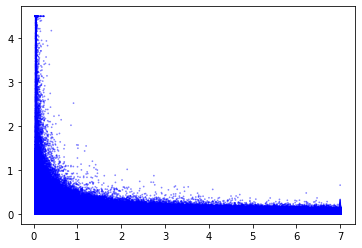

In [4]:
plt.scatter(var_output['CABLE_VPDl'],var_output['model_CABLE'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')


In [ ]:
plt.scatter(var_output['model_MuSICA'],var_output['model_MATSIRO'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
# plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')

In [ ]:
plt.scatter(var_output['model_JULES_GL9_withLAI'],var_output['model_JULES_test'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
# plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')

In [ ]:
plt.scatter(var_output['model_ORC3_r7245_NEE'],var_output['model_QUINCY'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')

## process1 LAI output vs PLUMBER 2 original nc files

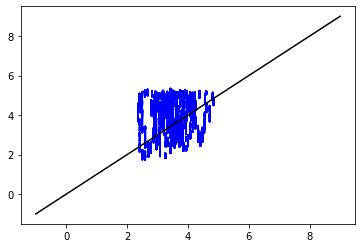

In [97]:
site_name = "AU-Tum"
site_mask = var_output['site_name'].values == site_name
plt.scatter(var_output[site_mask]['obs_LAI'],var_output[site_mask]['NoahMPv401_LAI'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')


['/g/data/w97/mm3972/data/PLUMBER2/NoahMPv401/NoahMPv401_UAlb_r1a_AU-Tum.nc']
['/g/data/w97/mm3972/data/Fluxnet_data/Post-processed_PLUMBER2_outputs/Nc_files/Met/AU-Tum_2002-2017_OzFlux_Met.nc']


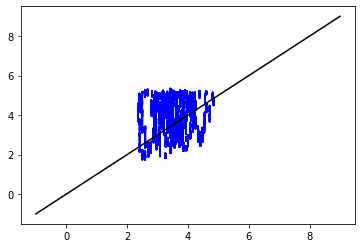

In [99]:
model_name     = 'NoahMPv401'
file_path      = glob.glob(PLUMBER2_path+model_name +"/*"+site_name+"*.nc")
print(file_path)
fmodel         = nc.Dataset(file_path[0]) 
file_path      = glob.glob(PLUMBER2_met_path+"*"+site_name+"*.nc")
print(file_path)
fobs           = nc.Dataset(file_path[0]) 
LAI_model = fmodel.variables['LAI'][:]
LAI_obs   = fobs.variables['LAI'][:]
plt.scatter(LAI_obs, LAI_model, s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')

# Check PLUMBER 2 process2 output file

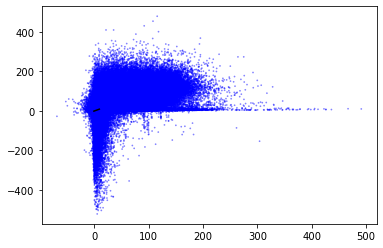

In [100]:
process_name = "process2_output/daily"
var_output   = pd.read_csv(f'{PLUMBER2_txt}{process_name}/Qle_all_sites_daily.csv',na_values=[''],usecols=['obs','model_GFDL','model_CABLE'])
plt.scatter(var_output['obs'],var_output['model_GFDL'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-200,600),np.arange(-200,600),c='black')

## Check process2 daily LAI

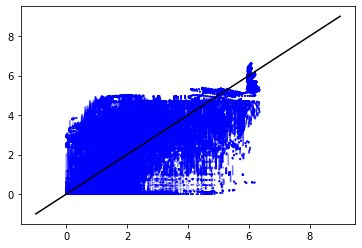

In [114]:
process_name = "process2_output/daily"
var_output   = pd.read_csv(f'{PLUMBER2_txt}{process_name}/LAI_all_sites_daily.csv',na_values=[''])

# half_hrs_after_precip,obs_LAI,ORC2_r6593_LAI,ORC2_r6593_CO2_LAI,ORC3_r7245_NEE_LAI,ORC3_r8120_LAI,GFDL_LAI,SDGVM_LAI,QUINCY_LAI,NoahMPv401_LAI
plt.scatter(var_output['obs_LAI'],var_output['ORC2_r6593_LAI'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')

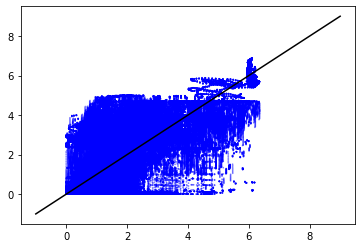

In [115]:
# half_hrs_after_precip,obs_LAI,ORC2_r6593_LAI,ORC2_r6593_CO2_LAI,ORC3_r7245_NEE_LAI,ORC3_r8120_LAI,GFDL_LAI,SDGVM_LAI,QUINCY_LAI,NoahMPv401_LAI
plt.scatter(var_output['obs_LAI'],var_output['ORC2_r6593_CO2_LAI'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')

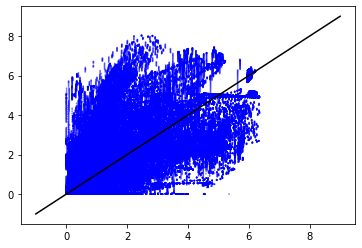

In [116]:
# half_hrs_after_precip,obs_LAI,ORC2_r6593_LAI,ORC2_r6593_CO2_LAI,ORC3_r7245_NEE_LAI,ORC3_r8120_LAI,GFDL_LAI,SDGVM_LAI,QUINCY_LAI,NoahMPv401_LAI
plt.scatter(var_output['obs_LAI'],var_output['ORC3_r7245_NEE_LAI'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')

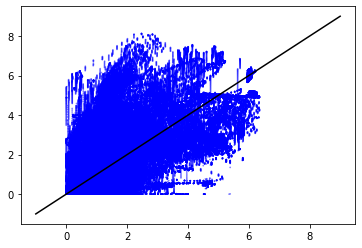

In [117]:
# half_hrs_after_precip,obs_LAI,ORC2_r6593_LAI,ORC2_r6593_CO2_LAI,ORC3_r7245_NEE_LAI,ORC3_r8120_LAI,GFDL_LAI,SDGVM_LAI,QUINCY_LAI,NoahMPv401_LAI
plt.scatter(var_output['obs_LAI'],var_output['ORC3_r8120_LAI'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')

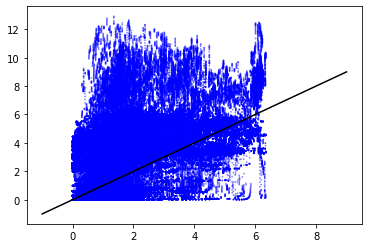

In [118]:
# half_hrs_after_precip,obs_LAI,ORC2_r6593_LAI,ORC2_r6593_CO2_LAI,ORC3_r7245_NEE_LAI,ORC3_r8120_LAI,GFDL_LAI,SDGVM_LAI,QUINCY_LAI,NoahMPv401_LAI
plt.scatter(var_output['obs_LAI'],var_output['GFDL_LAI'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')

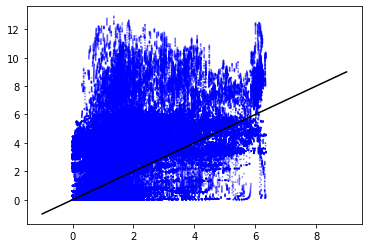

In [119]:
# half_hrs_after_precip,obs_LAI,ORC2_r6593_LAI,ORC2_r6593_CO2_LAI,ORC3_r7245_NEE_LAI,ORC3_r8120_LAI,GFDL_LAI,SDGVM_LAI,QUINCY_LAI,NoahMPv401_LAI
plt.scatter(var_output['obs_LAI'],var_output['SDGVM_LAI'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')

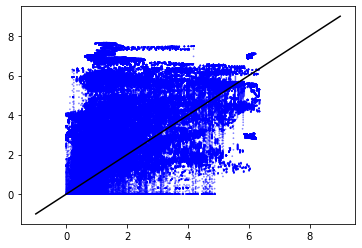

In [120]:
# half_hrs_after_precip,obs_LAI,ORC2_r6593_LAI,ORC2_r6593_CO2_LAI,ORC3_r7245_NEE_LAI,ORC3_r8120_LAI,GFDL_LAI,SDGVM_LAI,QUINCY_LAI,NoahMPv401_LAI
plt.scatter(var_output['obs_LAI'],var_output['QUINCY_LAI'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')

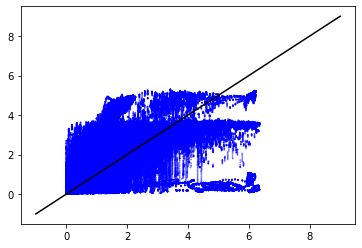

In [121]:
# half_hrs_after_precip,obs_LAI,ORC2_r6593_LAI,ORC2_r6593_CO2_LAI,ORC3_r7245_NEE_LAI,ORC3_r8120_LAI,GFDL_LAI,SDGVM_LAI,QUINCY_LAI,NoahMPv401_LAI
plt.scatter(var_output['obs_LAI'],var_output['NoahMPv401_LAI'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(-1,10),np.arange(-1,10),c='black')

## Check Gs

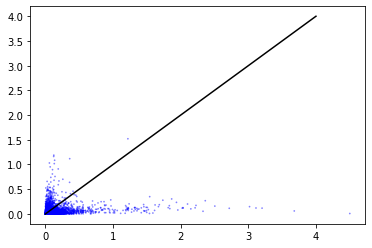

In [6]:
var_output   = pd.read_csv("/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process2_output/daily/Gs_all_sites_daily.csv",
                           na_values=[''],usecols=["model_CABLE","CABLE_VPDl","obs","obs_VPDl","model_CABLE-POP-CN","CABLE-POP-CN_VPDl"])
plt.scatter(var_output['obs'],var_output['model_CABLE'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(0,5),np.arange(0,5),c='black')

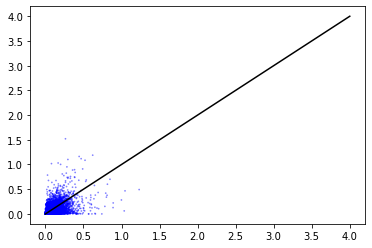

In [7]:
plt.scatter(var_output['model_CABLE-POP-CN'],var_output['model_CABLE'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(0,5),np.arange(0,5),c='black')

# Check Process1 Gs filter

In [29]:
Gs_filter   = pd.read_csv("/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Gs_all_sites_filtered.csv", na_values=['']) # , usecols=['model_CABLE']
Gs_orig     = pd.read_csv("/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Gs_all_sites.csv", na_values=['']) # , usecols=['model_CABLE']
Gs_orig['obs_Wind'] = Gs_filter['obs_Wind']

In [14]:
# Gs_orig.loc[(Gs_orig['Gs']<0) | (Gs_orig['Gs']>4.5), 'Gs'] = np.nan
# Gs_filter.loc[(Gs_filter['Gs']<0) | (Gs_filter['Gs']>4.5), 'Gs'] = np.nan

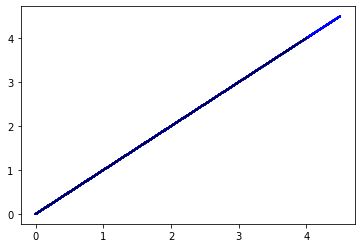

In [6]:
plt.scatter(Gs_orig['model_CABLE'],Gs_filter['model_CABLE'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(0,5),np.arange(0,5),c='black')

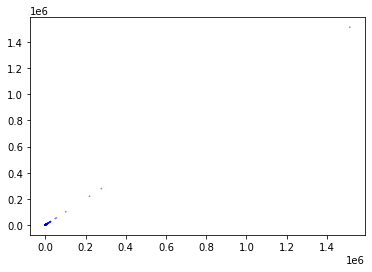

In [9]:
plt.scatter(Gs_orig['model_CABLE'],Gs_orig['model_CABLE'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(0,5),np.arange(0,5),c='black')

In [50]:
Gs_filter_out = Gs_orig[Gs_orig['obs']>4.5]


In [59]:
# Low sunlight caused abnormal Gs values
print(np.sum((Gs_filter_out['obs_SWdown']<5))/len(Gs_filter_out['obs_SWdown']))

0.43638247837697797


In [56]:
# Low sunlight & rainfall caused abnormal Gs values
print(np.sum((Gs_filter_out['obs_Precip']>0.0)|(Gs_filter_out['obs_SWdown']<5))/len(Gs_filter_out['obs_SWdown']))

0.5533660169795528


In [57]:
# Low sunlight & low wind speed & rainfall caused abnormal Gs values
print(np.sum((Gs_filter_out['obs_Precip']>0.0)|(Gs_filter_out['obs_SWdown']<5)|(Gs_filter_out['obs_Wind']<1.))/len(Gs_filter_out['obs_SWdown']))

0.6030850173382757


In [58]:
# Low sunlight & low wind speed & low VPD & rainfall caused abnormal Gs values
print(np.sum((Gs_filter_out['obs_Precip']>0.0)|(Gs_filter_out['obs_SWdown']<5)|(Gs_filter_out['obs_Wind']<1.) | (Gs_filter_out['VPD']<=0.05))/len(Gs_filter_out['obs_SWdown']))

0.760636135358125


That is to say, there is still 34% of Gs>4.5 cannot be explained by low radiation, low wind speed, low VPD and rainy day.

In [39]:
rad_p_wind_mask = ~((Gs_filter_out['obs_Precip']>0.0)|(Gs_filter_out['obs_SWdown']<0.05)|(Gs_filter_out['obs_Wind']<1.))

In [43]:
len(Gs_filter_out[rad_p_wind_mask]['model_CABLE'])

26582

<AxesSubplot:xlabel='model_CABLE', ylabel='Density'>

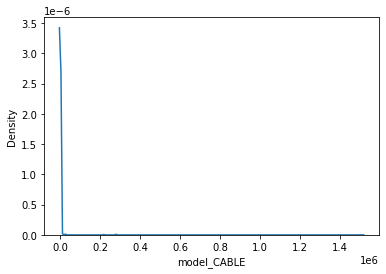

In [46]:
import seaborn as sns
# Plot the PDF
sns.kdeplot(Gs_filter_out[rad_p_wind_mask]['model_CABLE'])

In [48]:
np.sum(Gs_filter_out[rad_p_wind_mask]['model_CABLE']<100)/len(Gs_filter_out[rad_p_wind_mask]['model_CABLE'])

0.9608381611616884

# Check CMIP6

In [ ]:
input_file = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/CMIP6/CMIP6_Qle_historical_global.csv"

In [ ]:
var_input = pd.read_csv(input_file)

In [ ]:
plt.scatter(var_input['VPD'],var_input['Qle'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
# plt.plot(np.arange(0,5),np.arange(0,5),c='black')

# Check process3 EF_obs

In [19]:
input_file = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process3_output/curves/raw_data_Qle_VPD_hourly_RM16_DT_EF_obs_0-0.2.csv"

In [20]:
var_input = pd.read_csv(input_file)

In [21]:
var_input

,Unnamed: 0.1,Unnamed: 0,time,model_CABLE,CABLE_EF,model_CABLE-POP-CN,CABLE-POP-CN_EF,model_CHTESSEL_Ref_exp1,CHTESSEL_Ref_exp1_EF,model_CLM5a,...,MATSIRO_SMtop1m,MuSICA_SMtop1m,NASAEnt_SMtop1m,NoahMPv401_SMtop1m,ORC2_r6593_SMtop1m,ORC3_r8120_SMtop1m,QUINCY_SMtop1m,STEMMUS-SCOPE_SMtop1m,obs_SMtop1m,model_mean_SMtop1m
0,12,12,2010-01-01 06:30:00,NaN,0.526731,NaN,0.416425,NaN,0.543061,NaN,...,0.103217,0.165701,NaN,0.159520,0.056372,0.056042,NaN,0.117221,NaN,0.115941
1,13,13,2010-01-01 07:00:00,NaN,0.507929,NaN,0.420786,NaN,0.485329,NaN,...,0.103206,0.165696,NaN,0.159512,0.056346,0.056017,NaN,0.117249,NaN,0.115932
2,14,14,2010-01-01 07:30:00,NaN,0.529003,NaN,0.336133,NaN,0.457484,NaN,...,0.103186,0.165689,NaN,0.159501,0.056315,0.055986,NaN,0.117273,NaN,0.115918
3,15,15,2010-01-01 08:00:00,NaN,0.613327,NaN,0.370076,NaN,0.477366,NaN,...,0.103153,0.165677,NaN,0.159485,0.056267,0.055937,NaN,0.117290,NaN,0.115894
4,16,16,2010-01-01 08:30:00,NaN,0.651370,NaN,0.434876,NaN,0.510675,NaN,...,0.103100,0.165652,NaN,0.159456,0.056181,0.055852,NaN,0.117287,NaN,0.115848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8133181,17137977,17137977,2008-12-31 17:00:00,NaN,0.102226,NaN,0.530175,NaN,0.102767,NaN,...,0.090440,0.067514,NaN,0.103324,0.093370,0.093370,NaN,0.057530,NaN,0.093370
8133182,17137978,17137978,2008-12-31 17:30:00,NaN,0.098268,NaN,NaN,NaN,0.114944,NaN,...,0.090409,0.067514,NaN,0.103316,0.093365,0.093365,NaN,0.057531,NaN,0.093365
8133183,17137979,17137979,2008-12-31 18:00:00,NaN,0.064568,NaN,0.969807,NaN,0.124460,NaN,...,0.090387,0.067513,NaN,0.103311,0.093362,0.093362,NaN,0.057531,NaN,0.093362
8133184,17137980,17137980,2008-12-31 18:30:00,NaN,0.031835,NaN,0.759698,NaN,0.085782,NaN,...,0.090376,0.067513,NaN,0.103309,0.093362,0.093362,NaN,0.057531,NaN,0.093362


In [27]:
mask = (var_input['obs_EF']>0.2) & (~np.isnan(var_input['model_CABLE']))

In [28]:
var_input.loc[mask,'obs_EF']

Series([], Name: obs_EF, dtype: float64)

In [29]:
var_input.loc[mask,'model_CABLE']

Series([], Name: model_CABLE, dtype: float64)

In [ ]:
for i in np.arange(8133186):
    if var_input['obs_EF'][i]<=0.2 and ~np.isnan(var_input['model_CABLE'][i]):
        print(var_input['obs_EF'][i],var_input['model_CABLE'][i])

# Check process3 VPD_caused ET

In [5]:
file_name = '/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process3_output/curves/raw_data_Qle_VPD_hourly_RM16_DT_EF_model_0.8-1.0.csv'

In [10]:
var_input = pd.read_csv(file_name,usecols=['obs_VPD_caused_ratio'])

In [7]:
var_input

,obs_VPD_caused
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
6683643,NaN
6683644,NaN
6683645,NaN
6683646,NaN


In [11]:
np.any(~np.isnan(var_input))

False

In [23]:
file_name = '/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Rnet_caused_LH_ratio/Rnet_caused_LH_ratio_ZA-Kru_CLM5a.csv'

In [24]:
var_input = pd.read_csv(file_name,usecols=['Rnet_caused_ratio'])

In [25]:
var_input

,Rnet_caused_ratio
0,0.173234
1,0.206147
2,0.231400
3,0.240158
4,0.230791
...,...
52603,0.013872
52604,0.021781
52605,0.034861
52606,0.048226


In [26]:
np.any(~np.isnan(var_input))

True

# Check Rnet caused LH ratio

In [9]:
file_name = '/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Rnet_caused_ratio_all_sites.csv'

In [10]:
var_input = pd.read_csv(file_name,usecols=['obs','VPD','model_NASAEnt','VPD','model_MATSIRO','model_JULES_GL9','model_CABLE'])

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [7]:
len(var_input)

17137992

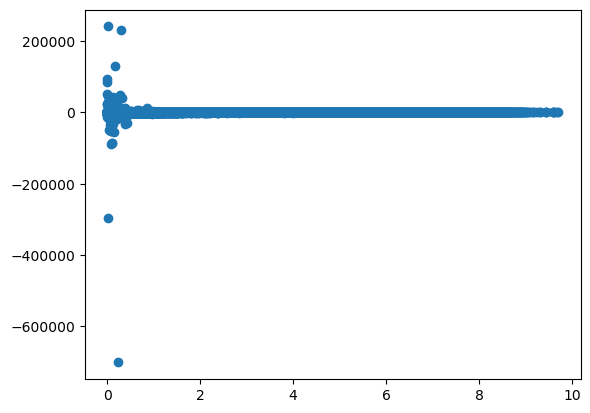

In [5]:
plt.scatter(var_input['VPD'],var_input['obs'])

In [24]:
var_new = var_input[(var_input['obs']>0) & (var_input['obs']<1)]

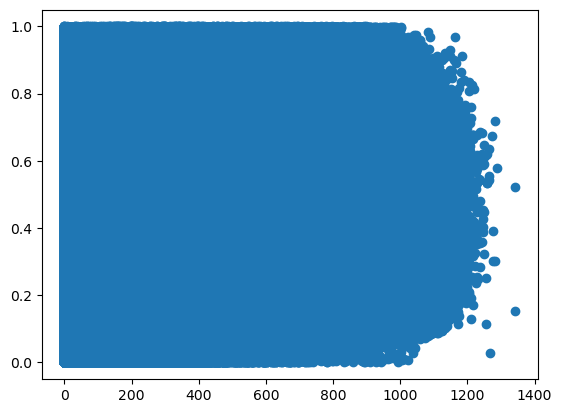

In [26]:
plt.scatter(var_new['obs_SWdown'],var_new['obs'])

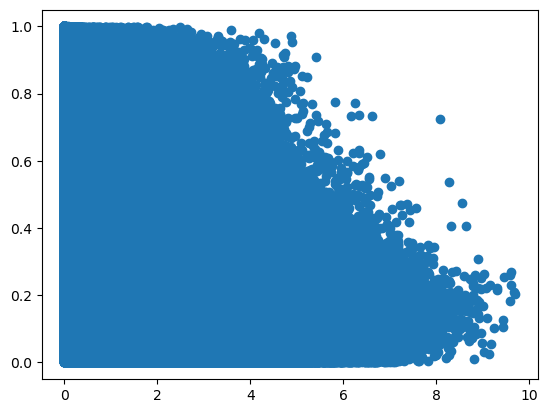

In [27]:
plt.scatter(var_new['VPD'],var_new['obs'])

In [30]:
var_new = var_input[(var_input['obs_SWdown']>60)]

In [15]:
len(var_new)

6806749

In [53]:
var_new = var_input[(var_input['model_JULES_GL9']>0) & (var_input['model_JULES_GL9']<1) & (var_input['obs']>0) & (var_input['obs']<1)]

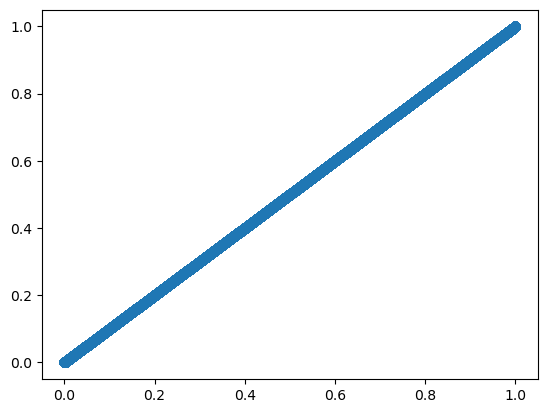

In [54]:
plt.scatter(var_new['model_JULES_GL9'],var_new['obs'])

# Check Rnet caused LH ratio at single site

In [ ]:
file_name_CABLE = '/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Rnet_caused_LH_ratio/Rnet_caused_LH_ratio_AU-Tum_CABLE.csv'

In [ ]:
file_name_obs = '/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Rnet_caused_LH_ratio/Rnet_caused_LH_ratio_AU-Tum_obs.csv'

In [ ]:
var_input_CABLE = pd.read_csv(file_name_CABLE)

In [ ]:
var_input_obs   = pd.read_csv(file_name_obs)

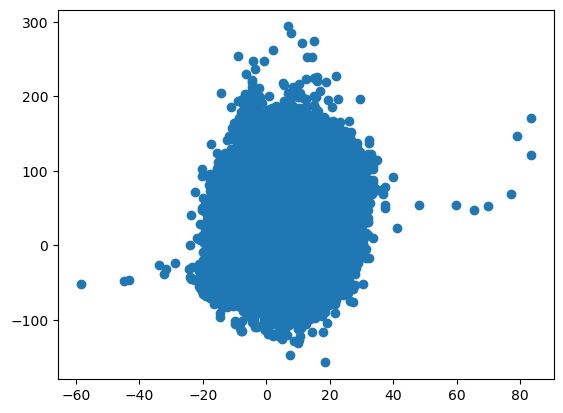

In [63]:
plt.scatter(var_input_obs['Qg'],var_input_CABLE['Qg'])

# Check SWdown, VPD and LH relationship

In [38]:
file_name = '/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Qle_all_sites.csv' 

In [39]:
var_input = pd.read_csv(file_name,usecols=['obs_SWdown','obs','obs_EF','IGBP_type','site_name','climate_type','VPD','model_QUINCY'])

### check site numbers

In [36]:
mask_VPD6        = (var_input['VPD']>0) &   (var_input['VPD']<1) 
np.unique(var_input[mask_VPD6]['climate_type'])

array(['Af', 'Am', 'Aw', 'BSh', 'BSk', 'BWh', 'BWk', 'Cfa', 'Cfb', 'Csa',
       'Csb', 'Cwa', 'Dfa', 'Dfb', 'Dfc', 'Dsb', 'Dsc', 'Dwa', 'Dwb',
       'ET'], dtype=object)

In [27]:
mask_VPD6        = (var_input['VPD']>1) &   (var_input['VPD']<2) 
np.unique(var_input[mask_VPD6]['climate_type'])

array(['Af', 'Am', 'Aw', 'BSh', 'BSk', 'BWh', 'BWk', 'Cfa', 'Cfb', 'Csa',
       'Csb', 'Cwa', 'Dfa', 'Dfb', 'Dfc', 'Dsb', 'Dsc', 'Dwa', 'Dwb',
       'ET'], dtype=object)

In [28]:
mask_VPD6        = (var_input['VPD']>2) &   (var_input['VPD']<3) 
np.unique(var_input[mask_VPD6]['climate_type'])

array(['Af', 'Am', 'Aw', 'BSh', 'BSk', 'BWh', 'BWk', 'Cfa', 'Cfb', 'Csa',
       'Csb', 'Cwa', 'Dfa', 'Dfb', 'Dfc', 'Dsb', 'Dsc', 'Dwa', 'Dwb',
       'ET'], dtype=object)

In [29]:
mask_VPD6        = (var_input['VPD']>3) &   (var_input['VPD']<4) 
np.unique(var_input[mask_VPD6]['climate_type'])

array(['Af', 'Am', 'Aw', 'BSh', 'BSk', 'BWh', 'BWk', 'Cfa', 'Cfb', 'Csa',
       'Csb', 'Cwa', 'Dfa', 'Dfb', 'Dfc', 'Dsb', 'Dsc', 'Dwa', 'Dwb'],
      dtype=object)

In [30]:
mask_VPD6        = (var_input['VPD']>4) &   (var_input['VPD']<5) 
np.unique(var_input[mask_VPD6]['climate_type'])

array(['Am', 'Aw', 'BSh', 'BSk', 'BWh', 'BWk', 'Cfa', 'Cfb', 'Csa', 'Csb',
       'Cwa', 'Dfa', 'Dfb', 'Dfc', 'Dsb', 'Dsc', 'Dwa', 'Dwb'],
      dtype=object)

In [31]:
mask_VPD6        = (var_input['VPD']>5) &   (var_input['VPD']<6) 
np.unique(var_input[mask_VPD6]['climate_type'])

array(['Aw', 'BSh', 'BSk', 'BWh', 'BWk', 'Cfa', 'Cfb', 'Csa', 'Csb',
       'Cwa', 'Dfa', 'Dfb', 'Dfc', 'Dsb'], dtype=object)

In [32]:
mask_VPD6        = (var_input['VPD']>6) &   (var_input['VPD']<7) 
np.unique(var_input[mask_VPD6]['climate_type'])

array(['Aw', 'BSh', 'BSk', 'BWh', 'BWk', 'Cfa', 'Cfb', 'Csa', 'Csb',
       'Dsb'], dtype=object)

In [33]:
mask_VPD6        = (var_input['VPD']>7) &   (var_input['VPD']<8) 
np.unique(var_input[mask_VPD6]['climate_type'])

array(['BSh', 'BSk', 'BWh', 'BWk', 'Cfa', 'Csa'], dtype=object)

In [35]:
mask_VPD6        = (var_input['VPD']>8) &   (var_input['VPD']<9) 
np.unique(var_input[mask_VPD6]['climate_type'])

array(['BSh', 'BWh', 'BWk', 'Cfa', 'Csa'], dtype=object)

In [83]:
import scipy.stats as stats
mask        = (var_input['obs_SWdown']>300) & (var_input['obs_SWdown']<650) & (var_input['obs_EF']>0.8) & (var_input['obs_EF']<1.0) & (~np.isnan(var_input['obs']))
var_day     = var_input[mask]
mask_dawn   = (var_input['obs_SWdown']>50) & (var_input['obs_SWdown']<300) & (var_input['obs_EF']>0.8) & (var_input['obs_EF']<1.0) & (~np.isnan(var_input['obs']))
var_dawn    = var_input[mask_dawn]
mask_midday = (var_input['obs_SWdown']>650) & (var_input['obs_EF']>0.8) & (var_input['obs_EF']<1.0) & (~np.isnan(var_input['obs']))
var_midday  = var_input[mask_midday]

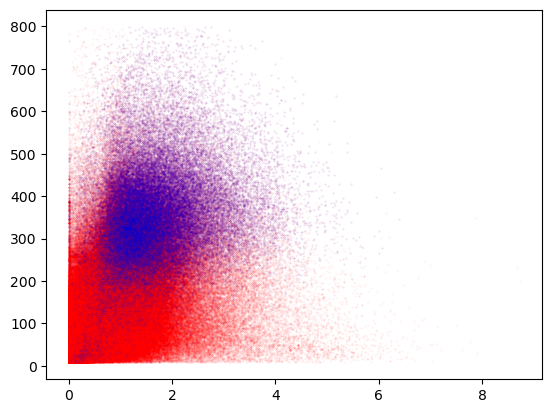

In [166]:
plt.scatter(var_day['VPD'],var_day['obs'],s=0.1,alpha=0.1,c='red')
plt.scatter(var_midday['VPD'],var_midday['obs'],s=0.1,alpha=0.1,c='blue')


In [118]:
r,p = stats.pearsonr(var_day['obs_SWdown'], var_day['obs'])

In [119]:
print(f"Pearson correlation coefficient (r): {r}")
print(f"p-value: {p:.40e}")

Pearson correlation coefficient (r): 0.003948937645148705
p-value: 3.5831994324736966307798358144509620615281e-03


In [120]:
clim_all = np.unique(var_day['climate_type'])

In [121]:
print(clim_all)

['Af' 'Am' 'Aw' 'BSh' 'BSk' 'BWh' 'BWk' 'Cfa' 'Cfb' 'Csa' 'Csb' 'Dfa'
 'Dfb' 'Dfc' 'Dsb' 'Dsc' 'Dwa' 'Dwb' 'ET']


## Tropical Climates (Group A)
Af - Tropical Rainforest Climate
No dry season; all months have precipitation.
Am - Tropical Monsoon Climate
Short dry season; significant rainfall during the wet season.
Aw - Tropical Savanna Climate
Distinct dry season in winter.

(-100.0, 800.0)

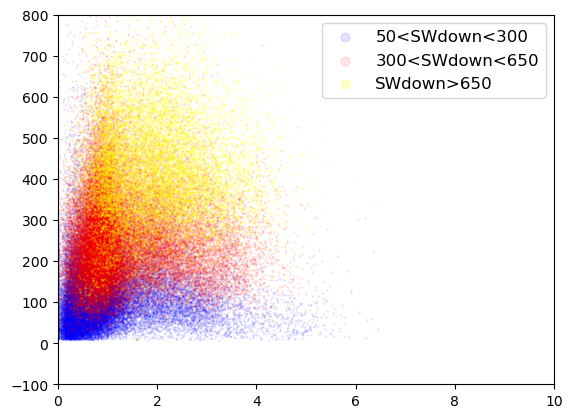

In [141]:
# for clim in clim_all:
clim_mask        = (var_day['climate_type']=='Aw') | (var_day['climate_type']=='Am') | (var_day['climate_type']=='Af')
clim_mask_dawn   = (var_dawn['climate_type']=='Aw') | (var_dawn['climate_type']=='Am') | (var_dawn['climate_type']=='Af')
clim_mask_midday = (var_midday['climate_type']=='Aw') | (var_midday['climate_type']=='Am') | (var_midday['climate_type']=='Af')
var_new          = var_day[clim_mask]
var_new_dawn     = var_dawn[clim_mask_dawn]
var_new_midday   = var_midday[clim_mask_midday]

plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 800)

(-100.0, 1400.0)

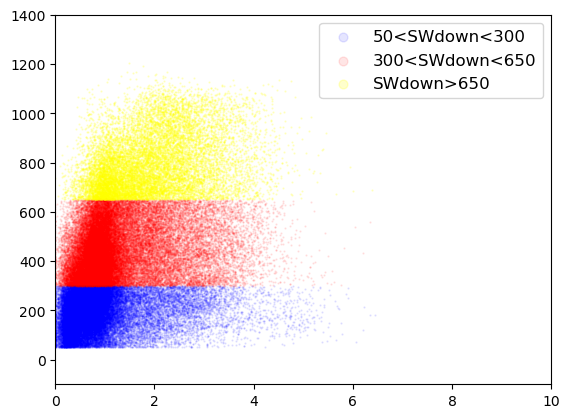

In [142]:
plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs_SWdown'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs_SWdown'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs_SWdown'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 1400)

## Dry Climates (Group B)
BSh - Hot Semi-Arid Climate (Steppe)
Semi-arid with hot temperatures.
BSk - Cold Semi-Arid Climate (Steppe)
Semi-arid with cooler temperatures.
BWh - Hot Desert Climate
Arid with extremely hot temperatures.
BWk - Cold Desert Climate
Arid with cooler temperatures.

(-100.0, 800.0)

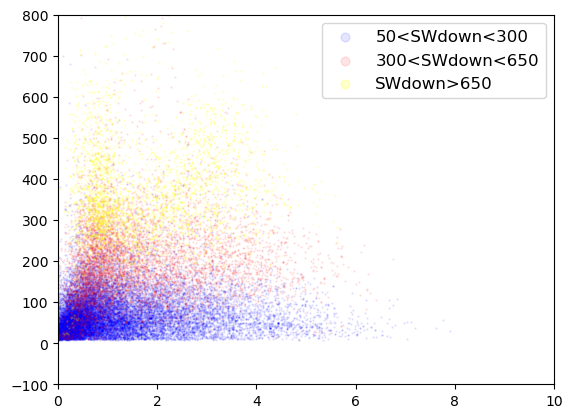

In [143]:
clim_mask        = (var_day['climate_type']=='BSh') | (var_day['climate_type']=='BSk') | (var_day['climate_type']=='BWh') | (var_day['climate_type']=='BWk')
clim_mask_dawn   = (var_dawn['climate_type']=='BSh') | (var_dawn['climate_type']=='BSk') | (var_dawn['climate_type']=='BWh') | (var_dawn['climate_type']=='BWk')
clim_mask_midday = (var_midday['climate_type']=='BSh') | (var_midday['climate_type']=='BSk') | (var_midday['climate_type']=='BWh') | (var_midday['climate_type']=='BWk')
var_new          = var_day[clim_mask]
var_new_dawn     = var_dawn[clim_mask_dawn]
var_new_midday   = var_midday[clim_mask_midday]
# print(clim)
plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 800)

(-100.0, 1400.0)

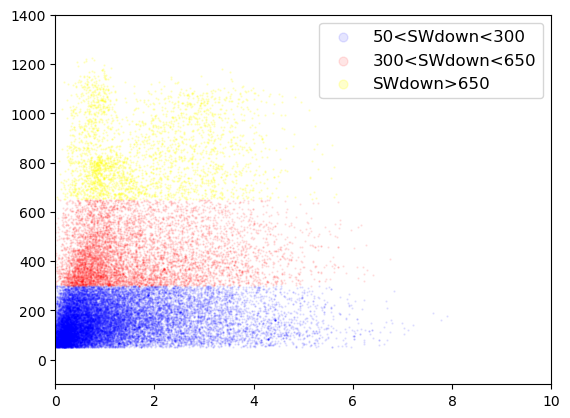

In [144]:
plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs_SWdown'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs_SWdown'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs_SWdown'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 1400)

## Temperate Climates (Group C)
Cfa - Humid Subtropical Climate
No dry season; hot summers.
Cfb - Oceanic Climate
No dry season; warm summers.
Csa - Mediterranean Climate (Hot Summer)
Dry summer, hot summer.
Csb - Mediterranean Climate (Warm Summer)
Dry summer, warm summer.

(-100.0, 800.0)

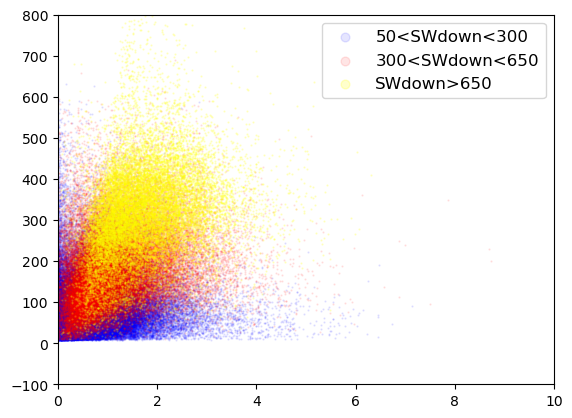

In [145]:
clim_mask        = (var_day['climate_type']=='Cfa') | (var_day['climate_type']=='Cfb') | (var_day['climate_type']=='Csa') | (var_day['climate_type']=='Csb')
clim_mask_dawn   = (var_dawn['climate_type']=='Cfa') | (var_dawn['climate_type']=='Cfb') | (var_dawn['climate_type']=='Csa') | (var_dawn['climate_type']=='Csb')
clim_mask_midday = (var_midday['climate_type']=='Cfa') | (var_midday['climate_type']=='Cfb') | (var_midday['climate_type']=='Csa') | (var_midday['climate_type']=='Csb')
var_new          = var_day[clim_mask]
var_new_dawn     = var_dawn[clim_mask_dawn]
var_new_midday   = var_midday[clim_mask_midday]
plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 800)

(-100.0, 1400.0)

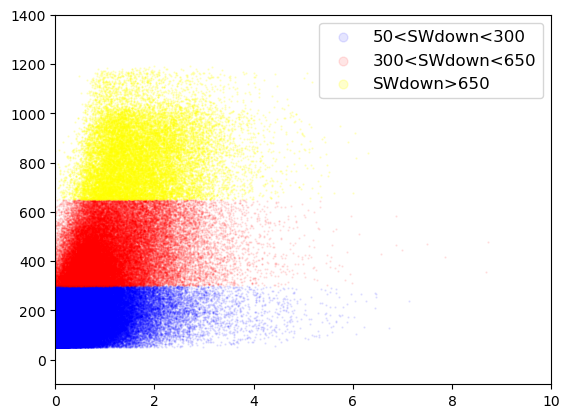

In [146]:
plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs_SWdown'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs_SWdown'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs_SWdown'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 1400)

## Continental Climates (Group D)
Dfa - Humid Continental Climate (Hot Summer)
No dry season; hot summers.
Dfb - Humid Continental Climate (Warm Summer)
No dry season; warm summers.
Dfc - Subarctic Climate
No dry season; cold summers.
Dsb - Mediterranean Climate (Warm Summer) with Continental Influence
Dry summer, warm summer, significant continental influence.
Dsc - Subarctic Climate with Dry Summer
Dry summer; cold summers.
Dwa - Monsoon-Influenced Hot Summer Continental Climate
Dry winter, hot summer.
Dwb - Monsoon-Influenced Warm Summer Continental Climate
Dry winter, warm summer.

(-100.0, 800.0)

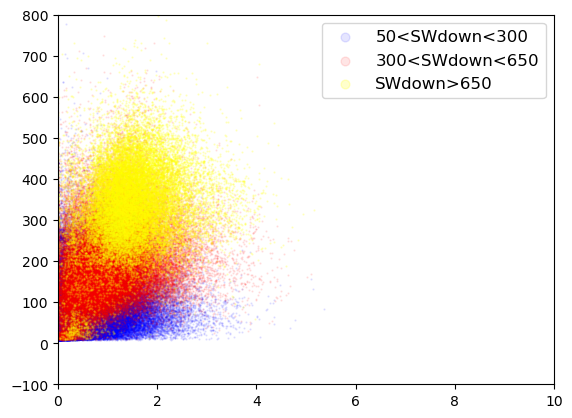

In [147]:
clim_mask        = (var_day['climate_type']=='Dfa') | (var_day['climate_type']=='Dfb') | (var_day['climate_type']=='Dfc') | (var_day['climate_type']=='Dsc') | (var_day['climate_type']=='Dwa') | (var_day['climate_type']=='Dwb')
clim_mask_dawn   = (var_dawn['climate_type']=='Dfa') | (var_dawn['climate_type']=='Dfb') | (var_dawn['climate_type']=='Dfc') | (var_dawn['climate_type']=='Dsc') | (var_dawn['climate_type']=='Dwa') | (var_dawn['climate_type']=='Dwb')
clim_mask_midday = (var_midday['climate_type']=='Dfa') | (var_midday['climate_type']=='Dfb') | (var_midday['climate_type']=='Dfc') | (var_midday['climate_type']=='Dsc') | (var_midday['climate_type']=='Dwa') | (var_midday['climate_type']=='Dwb')
var_new          = var_day[clim_mask]
var_new_dawn     = var_dawn[clim_mask_dawn]
var_new_midday   = var_midday[clim_mask_midday]
# print(clim)
plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 800)

(-100.0, 1400.0)

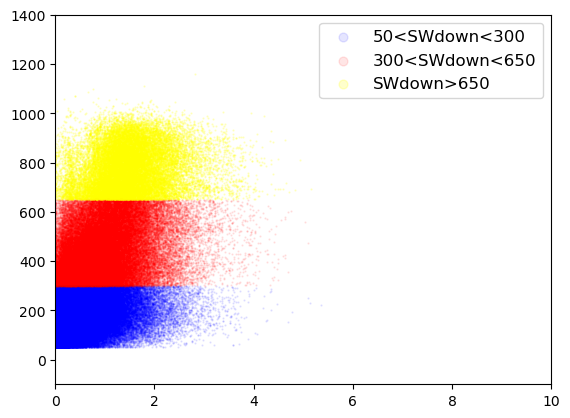

In [148]:
plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs_SWdown'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs_SWdown'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs_SWdown'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 1400)

## Polar Climates (Group E)
ET - Tundra Climate
Average temperature of the warmest month is between 0°C (32°F) and 10°C (50°F).

(-100.0, 800.0)

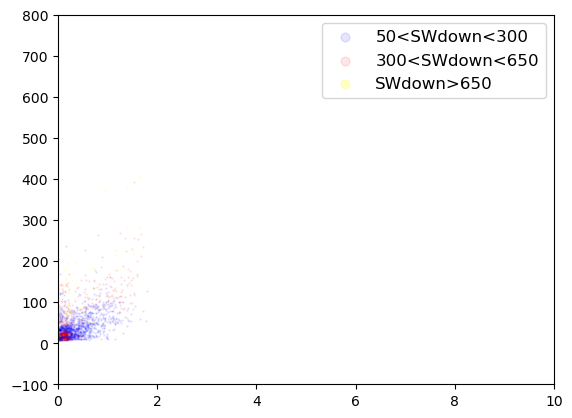

In [149]:
clim_mask        = (var_day['climate_type']=='ET') 
clim_mask_midday = (var_midday['climate_type']=='ET') 
clim_mask_dawn   = (var_dawn['climate_type']=='ET') 
var_new          = var_day[clim_mask]
var_new_midday   = var_midday[clim_mask_midday]
var_new_dawn     = var_dawn[clim_mask_dawn]
# print(clim)
plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 800)

(-100.0, 1400.0)

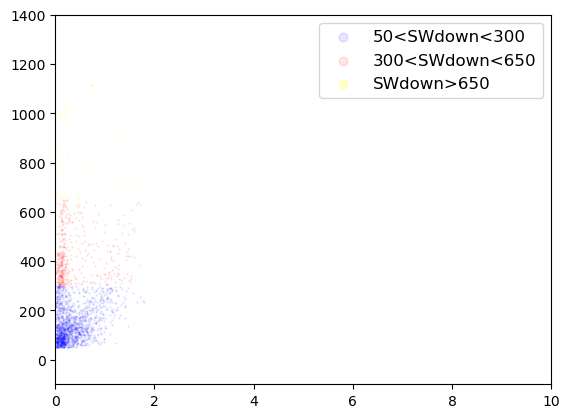

In [150]:
plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs_SWdown'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs_SWdown'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs_SWdown'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 1400)

# VPD caused

In [12]:
file_name         = '/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Rnet_caused_ratio_all_sites.csv'
Rnet_caused_ratio = pd.read_csv(file_name)

In [13]:
file_name = '/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process1_output/Qle_all_sites.csv' 
var_input = pd.read_csv(file_name,usecols=['obs_SWdown','obs','obs_EF','IGBP_type','site_name','climate_type','VPD','model_QUINCY'])

In [14]:
np.sum(~np.isnan(Rnet_caused_ratio['obs']))

16346591

In [15]:
np.sum(~np.isnan(var_input['obs'])) # nan comes from Qle>800 or Qle<-300

16927251

In [45]:
len(Rnet_caused_ratio['obs'])

17137992

In [55]:
np.sum(~np.isnan(Rnet_caused_ratio['VPD']))

17137992

In [46]:
len(var_input['obs'])
,time,CABLE_EF,CABLE-POP-CN_EF,CHTESSEL_Ref_exp1_EF,CLM5a_EF,GFDL_EF,JULES_GL9_EF,JULES_GL9_withLAI_EF,MATSIRO_EF,MuSICA_EF,NASAEnt_EF,
NoahMPv401_EF,ORC2_r6593_EF,ORC3_r8120_EF,QUINCY_EF,STEMMUS-SCOPE_EF,obs_EF,VPD,obs_Tair,obs_Qair,obs_Precip,obs_SWdown,
month,hour,site_name,IGBP_type,climate_type,model_CABLE,model_CABLE-POP-CN,model_CHTESSEL_Ref_exp1,model_CLM5a,model_GFDL,
model_JULES_GL9,model_JULES_GL9_withLAI,model_MATSIRO,model_MuSICA,model_NASAEnt,model_NoahMPv401,model_ORC2_r6593,
model_ORC3_r8120,model_QUINCY,model_STEMMUS-SCOPE,obs,obs_Wind


17137992

In [161]:
var_input['obs_VPD_caused'] = (1-Rnet_caused_ratio['obs'])*var_input['obs']

In [165]:
var_temp = var_input[~np.isnan(var_input['obs'])]
r,p      = stats.pearsonr(var_temp['obs'], var_temp['obs_SWdown'])

In [166]:
print(r,p)

0.6987295902653591 0.0


In [ ]:
r,p = stats.pearsonr(var_input['obs_VPD_caused'], var_input['obs_SWdown'])

# Check nan values in Rnet_caused_LH_ratio

In [7]:
file_name = "/g/data/w97/mm3972/data/Fluxnet_data/Post-processed_PLUMBER2_outputs/Nc_files/Flux/US-PFa_1995-2014_FLUXNET2015_Flux.nc"

In [8]:
f         = nc.Dataset(file_name)

In [10]:
Qle = f.variables['Qle'][:]
np.sum(np.isnan(Qle))

0

In [11]:
Qh  = f.variables['Qh'][:]
np.sum(np.isnan(Qh))

0

## Check EF>0.8 obs

In [97]:
import scipy.stats as stats
mask        = (var_input['obs_SWdown']>300) & (var_input['obs_SWdown']<650) & (var_input['obs_EF']>0.8) & (var_input['obs_EF']<1.0) & (~np.isnan(var_input['obs']))
var_day     = var_input[mask]
mask_dawn   = (var_input['obs_SWdown']>50) & (var_input['obs_SWdown']<300) & (var_input['obs_EF']>0.8) & (var_input['obs_EF']<1.0) & (~np.isnan(var_input['obs']))
var_dawn    = var_input[mask_dawn]
mask_midday = (var_input['obs_SWdown']>650) & (var_input['obs_EF']>0.8) & (var_input['obs_EF']<1.0) & (~np.isnan(var_input['obs']))
var_midday  = var_input[mask_midday]

(-100.0, 800.0)

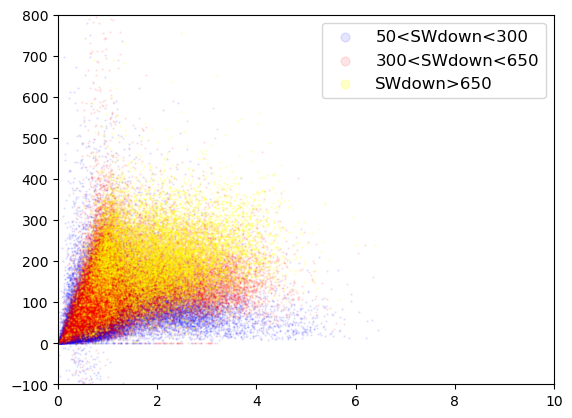

In [155]:
# for clim in clim_all:
clim_mask        = (var_day['climate_type']=='Aw') | (var_day['climate_type']=='Am') | (var_day['climate_type']=='Af')
clim_dawn_mask   = (var_dawn['climate_type']=='Aw') | (var_dawn['climate_type']=='Am') | (var_dawn['climate_type']=='Af')
clim_midday_mask = (var_midday['climate_type']=='Aw') | (var_midday['climate_type']=='Am') | (var_midday['climate_type']=='Af')
var_new          = var_day[clim_mask]
var_new_dawn     = var_dawn[clim_dawn_mask]
var_new_midday   = var_midday[clim_midday_mask]

plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs_VPD_caused'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs_VPD_caused'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs_VPD_caused'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 800)

(-100.0, 800.0)

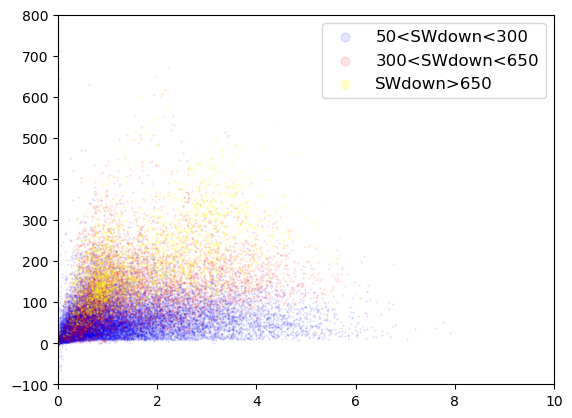

In [154]:
# for clim in clim_all:
clim_mask        = (var_day['climate_type']=='BSh') | (var_day['climate_type']=='BSk') | (var_day['climate_type']=='BWh') | (var_day['climate_type']=='BWk')
clim_mask_midday = (var_midday['climate_type']=='BSh') | (var_midday['climate_type']=='BSk') | (var_midday['climate_type']=='BWh') | (var_midday['climate_type']=='BWk')
clim_mask_dawn   = (var_dawn['climate_type']=='BSh') | (var_dawn['climate_type']=='BSk') | (var_dawn['climate_type']=='BWh') | (var_dawn['climate_type']=='BWk')

var_new          = var_day[clim_mask]
var_new_midday   = var_midday[clim_mask_midday]
var_new_dawn     = var_dawn[clim_mask_dawn]

plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs_VPD_caused'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs_VPD_caused'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs_VPD_caused'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 800)

(-100.0, 800.0)

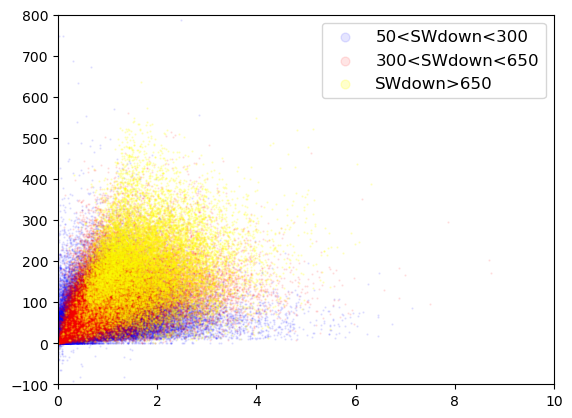

In [153]:
clim_mask        = (var_day['climate_type']=='Cfa') | (var_day['climate_type']=='Cfb') | (var_day['climate_type']=='Csa') | (var_day['climate_type']=='Csb')
clim_mask_midday = (var_midday['climate_type']=='Cfa') | (var_midday['climate_type']=='Cfb') | (var_midday['climate_type']=='Csa') | (var_midday['climate_type']=='Csb')
clim_mask_dawn   = (var_dawn['climate_type']=='Cfa') | (var_dawn['climate_type']=='Cfb') | (var_dawn['climate_type']=='Csa') | (var_dawn['climate_type']=='Csb')
var_new          = var_day[clim_mask]
var_new_midday   = var_midday[clim_mask_midday]
var_new_dawn     = var_dawn[clim_mask_dawn]
# print(clim)
plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs_VPD_caused'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs_VPD_caused'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs_VPD_caused'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 800)

(-100.0, 800.0)

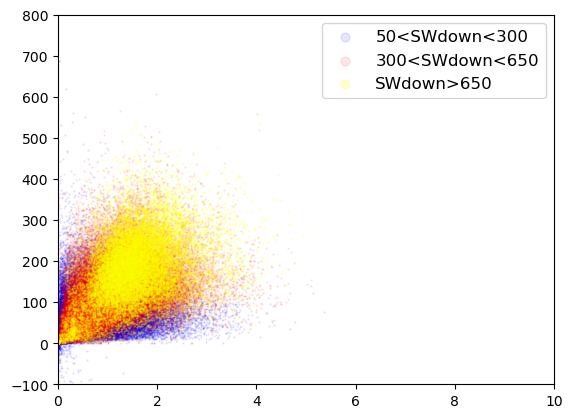

In [152]:
clim_mask        = (var_day['climate_type']=='Dfa') | (var_day['climate_type']=='Dfb') | (var_day['climate_type']=='Dfc') | (var_day['climate_type']=='Dsc') | (var_day['climate_type']=='Dwa') | (var_day['climate_type']=='Dwb')
clim_mask_midday = (var_midday['climate_type']=='Dfa') | (var_midday['climate_type']=='Dfb') | (var_midday['climate_type']=='Dfc') | (var_midday['climate_type']=='Dsc') | (var_midday['climate_type']=='Dwa') | (var_midday['climate_type']=='Dwb')
clim_mask_dawn   = (var_dawn['climate_type']=='Dfa') | (var_dawn['climate_type']=='Dfb') | (var_dawn['climate_type']=='Dfc') | (var_dawn['climate_type']=='Dsc') | (var_dawn['climate_type']=='Dwa') | (var_dawn['climate_type']=='Dwb')
var_new          = var_day[clim_mask]
var_new_midday   = var_midday[clim_mask_midday]
var_new_dawn     = var_dawn[clim_mask_dawn]
# print(clim)
plt.scatter(var_new_dawn['VPD'],var_new_dawn['obs_VPD_caused'],s=0.4,alpha=0.1,c='blue',label='50<SWdown<300')
plt.scatter(var_new['VPD'],var_new['obs_VPD_caused'],s=0.4,alpha=0.1,c='red',label='300<SWdown<650')
plt.scatter(var_new_midday['VPD'],var_new_midday['obs_VPD_caused'],s=0.4,alpha=0.2,c='yellow',label='SWdown>650')
plt.legend(fontsize=12,markerscale=10)
plt.xlim(0, 10)
plt.ylim(-100, 800)

In [96]:
import seaborn as sns
from scipy.stats import binned_statistic

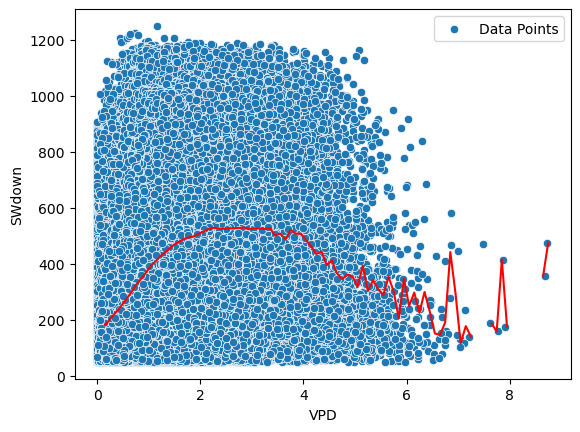

In [97]:
# Create a DataFrame
data = pd.DataFrame({'VPD': var_day['VPD'], 'SWdown': var_day['obs_SWdown']})

# Scatter plot using seaborn
sns.scatterplot(x='VPD', y='SWdown', data=data, label='Data Points')

# Calculate mean values for segments of x
bins = np.linspace(0.1, 10, 100)  # 20 bins
bin_means, bin_edges, binnumber = binned_statistic(var_day['VPD'], var_day['obs_SWdown'], statistic='mean', bins=bins)

# Plot mean curve
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.plot(bin_centers, bin_means, 'r-', label='Mean Curve')


In [67]:
mask = (var_input['obs_SWdown'] > 50) & (var_input['obs_EF'] > 0) & (var_input['obs_EF'] < 0.2)

In [ ]:
var_new = var_input